## This final project focuses on leveraging the techniques and concepts you've learned throughout this course.
- You will apply image processing, feature extraction, and pattern recognition methods to solve real-world challenges. Specifically, you will implement and fine-tune state-of-the-art algorithms like Convolutional Neural Networks (CNNs), object detection, image segmentation, or even feature matching.

![image-2.png](attachment:image-2.png)

we'll build a CNN using Keras to use it classifying thousands of pictures in six different categories

Data link : https://www.kaggle.com/puneet6060/intel-image-classification

#Import Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import cv2
import glob as gb
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
from tqdm import tqdm
from sklearn.metrics import classification_report, precision_recall_fscore_support
from google.colab import drive
from sklearn.model_selection import train_test_split



#define the path ( to swtich it between jupyter notebook & kaggle kernel)

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
os.getcwd()
train_path = r'/content/drive/My Drive/Colab Notebooks/computervision_project/seg_train/seg_train'
test_path = r'/content/drive/My Drive/Colab Notebooks/computervision_project/seg_test/seg_test'
pred_path = r'/content/drive/My Drive/Colab Notebooks/computervision_project/seg_pred/seg_pred'

# Open Folders

now let's first check the Train folder to have a look to its content

In [4]:
def count_images_in_folders(base_path, description):
    """
    Counts and prints the number of images in each folder within the specified base path.

    Parameters:
    - base_path: The path containing subfolders with images.
    - description: A string describing the type of data (e.g., 'training', 'testing', or 'prediction').
    """
    for folder in os.listdir(base_path):
        folder_path = os.path.join(base_path, folder)
        images = gb.glob(os.path.join(folder_path, '*.jpg'))
        print(f'For {description} data, found {len(images)} images in folder "{folder}".')

# Count images in training, testing, and prediction data
count_images_in_folders(train_path, 'training')
count_images_in_folders(test_path, 'testing')
count_images_in_folders(pred_path, 'prediction')

Streaming output truncated to the last 5000 lines.
For prediction data, found 0 images in folder "2398.jpg".
For prediction data, found 0 images in folder "2395.jpg".
For prediction data, found 0 images in folder "23924.jpg".
For prediction data, found 0 images in folder "23946.jpg".
For prediction data, found 0 images in folder "23894.jpg".
For prediction data, found 0 images in folder "23970.jpg".
For prediction data, found 0 images in folder "23944.jpg".
For prediction data, found 0 images in folder "23980.jpg".
For prediction data, found 0 images in folder "23963.jpg".
For prediction data, found 0 images in folder "23960.jpg".
For prediction data, found 0 images in folder "23914.jpg".
For prediction data, found 0 images in folder "23971.jpg".
For prediction data, found 0 images in folder "23913.jpg".
For prediction data, found 0 images in folder "23895.jpg".
For prediction data, found 0 images in folder "23905.jpg".
For prediction data, found 0 images in folder "23957.jpg".
For pre

#Checking Images
now we need to heck the images sizes , to know ow they looks like

since we have 6 categories , we first need to create a dictionary with their names & indices , also create a function to get the code back

In [5]:
code = {'buildings':0 ,'forest':1,'glacier':2,'mountain':3,'sea':4,'street':5}

def get_code(n):
    for x,y in code.items():
        if n==y:
            return x
get_code(3)

'mountain'

In [6]:
# def get_image_sizes(image_path, is_subfolder=False):
#     """
#     This function calculates the sizes of images in the given path.

#     Parameters:
#     - image_path: Path where images are stored.
#     - is_subfolder: Set to True if the images are in subfolders (like train/test sets).

#     Returns:
#     - A pandas Series with the count of each image size.
#     """
#     sizes = []

#     if is_subfolder:
#         for folder in os.listdir(image_path):
#             images = gb.glob(pathname=str(image_path + '/' + folder + '/*.jpg'))
#             for img in images:
#                 image = plt.imread(img)
#                 sizes.append(image.shape)
#     else:
#         files = gb.glob(pathname=str(image_path + '/*.jpg'))
#         for file in files:
#             image = plt.imread(file)
#             sizes.append(image.shape)

#     return pd.Series(sizes).value_counts()

# # Usage examples
# train_sizes = get_image_sizes(train_path, is_subfolder=True)
# test_sizes = get_image_sizes(test_path, is_subfolder=True)
# pred_sizes = get_image_sizes(pred_path, is_subfolder=False)

# print("Train Image Sizes:\n", train_sizes)
# print("Test Image Sizes:\n", test_sizes)
# print("Prediction Image Sizes:\n", pred_sizes)

ok , since almost all of pictures are 150,150,3 , we can feel comfort in using all pictures in our model , after resizing it in a specific amount

#Reading Images
now it's time to read all images & convert it into arrays

first we'll create a variable s , which refer to size , so we can change it easily

let's use now size = 100 , so it will be suitable amount to contain accuracy without losing so much time in training

In [7]:
# resized_shape=100

# def load_images(image_path, code, resize_shape=(150, 150), is_subfolder=True):
#     """
#     Loads and resizes images from the specified path.

#     Parameters:
#     - image_path: Path where images are stored.
#     - code: A dictionary mapping folder names to labels.
#     - resize_shape: Tuple specifying the new size for resizing images (default is (100, 100)).
#     - is_subfolder: Boolean indicating if images are in subfolders (True for train/test, False for prediction).

#     Returns:
#     - x_data: A NumPy array of resized images.
#     - y_data: Corresponding labels (if applicable, else returns None for prediction data).
#     """
#     x_data = []
#     y_data = []

#     if is_subfolder:
#         for folder in os.listdir(image_path):
#             folder_path = os.path.join(image_path, folder)
#             images = gb.glob(pathname=os.path.join(folder_path, '*.jpg'))
#             for img_path in images:
#                 image = plt.imread(img_path)  # Alternatively, you can use cv2.imread for BGR images###@@@@ plt.imread
#                 image_resized = cv2.resize(image, resize_shape)
#                 x_data.append(image_resized)
#                 y_data.append(code[folder])  # Append the folder's label
#     else:
#         images = gb.glob(pathname=os.path.join(image_path, '*.jpg'))
#         for img_path in images:
#             image = cv2.imread(img_path)
#             image_resized = cv2.resize(image, resize_shape)
#             x_data.append(image_resized)
#         y_data = None  # No labels for prediction data

#     return np.array(x_data), np.array(y_data)


# # Usage for train data
# x_train, y_train = load_images(train_path, code, resize_shape=(resized_shape, resized_shape), is_subfolder=True)

# # Usage for test data
# x_test, y_test = load_images(test_path, code, resize_shape=(resized_shape, resized_shape), is_subfolder=True)

# # Usage for prediction data (no labels)
# x_pred, _ = load_images(pred_path, code=None, resize_shape=(resized_shape, resized_shape), is_subfolder=False)

# print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")
# print(f"x_test shape: {x_test.shape}, y_test shape: {y_test.shape}")
# print(f"x_pred shape: {x_pred.shape}")

# import numpy as np

# # Save each array to .npy files on your drive
# np.save(r'/content/drive/My Drive/Colab Notebooks/computervision_project/x_train.npy', x_train)
# np.save(r'/content/drive/My Drive/Colab Notebooks/computervision_project/y_train.npy', y_train)
# np.save(r'/content/drive/My Drive/Colab Notebooks/computervision_project/x_test.npy', x_test)
# np.save(r'/content/drive/My Drive/Colab Notebooks/computervision_project/y_test.npy', y_test)
# np.save(r'/content/drive/My Drive/Colab Notebooks/computervision_project/x_pred.npy', x_pred)


In [8]:
# np.save(r'/content/drive/My Drive/Colab Notebooks/computervision_project/x_train.npy', x_train)
# np.save(r'/content/drive/My Drive/Colab Notebooks/computervision_project/y_train.npy', y_train)
# np.save(r'/content/drive/My Drive/Colab Notebooks/computervision_project/x_test.npy', x_test)
# np.save(r'/content/drive/My Drive/Colab Notebooks/computervision_project/y_test.npy', y_test)
# np.save(r'/content/drive/My Drive/Colab Notebooks/computervision_project/x_pred.npy', x_pred)

In [9]:
resized_shape=100

x_train = np.load(r'/content/drive/My Drive/Colab Notebooks/computervision_project/x_train.npy')
y_train = np.load(r'/content/drive/My Drive/Colab Notebooks/computervision_project/y_train.npy')
x_test = np.load(r'/content/drive/My Drive/Colab Notebooks/computervision_project/x_test.npy')
y_test = np.load(r'/content/drive/My Drive/Colab Notebooks/computervision_project/y_test.npy')
x_pred = np.load(r'/content/drive/My Drive/Colab Notebooks/computervision_project/x_pred.npy')


In [10]:

# Set a seed for reproducibility
seed_value = 42
np.random.seed(seed_value)

# Generate the same random permutation index for both x_train and y_train
permutation = np.random.permutation(len(x_train))
x_train = x_train[permutation]
y_train = y_train[permutation]

# Do the same for x_test
permutation_test = np.random.permutation(len(x_test))
x_test = x_test[permutation_test]
y_test = y_test[permutation_test]


In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, classification_report

x_train=np.array(x_train)
x_test=np.array(x_test)

y_train=np.array(y_train)
y_test=np.array(y_test)

x_pred=np.array(x_pred)

print(x_train.shape)
print(x_test.shape)

print(y_train.shape)
print(y_test.shape)

print(x_pred.shape)


num_classes = 6



(14074, 100, 100, 3)
(3000, 100, 100, 3)
(14074,)
(3000,)
(7311, 100, 100, 3)


In [12]:
x_train=x_train/255.0
x_test=x_test/255.0
x_pred=x_pred/255.0




In [13]:
#implement same as vgg16
KerasModel = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(200, activation='relu', kernel_size=(3,3), padding='same', input_shape=(resized_shape,resized_shape,3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(180, activation='relu', kernel_size=(3,3), padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(160, activation='relu', kernel_size=(3,3), padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D((2, 2)),

    tf.keras.layers.Conv2D(140, activation='relu', kernel_size=(3,3), padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(120, activation='relu', kernel_size=(3,3), padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D((2, 2)),

    tf.keras.layers.Conv2D(100, activation='relu', kernel_size=(3,3), padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(80, activation='relu', kernel_size=(3,3), padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(60, activation='relu', kernel_size=(3,3), padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D((2, 2)),

    tf.keras.layers.Conv2D(140, activation='relu', kernel_size=(3,3), padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(120, activation='relu', kernel_size=(3,3), padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D((2, 2)),

    tf.keras.layers.Conv2D(50, activation='relu', kernel_size=(3,3), padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(40, activation='relu', kernel_size=(3,3), padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(40, activation='relu', kernel_size=(3,3), padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(30, activation='relu', kernel_size=(3,3), padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(20, activation='relu', kernel_size=(3,3), padding='same'),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(rate=0.8),
    tf.keras.layers.Dense(6, activation='softmax')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [14]:
# Define your desired learning rate
learning_rate = 0.001 # Change this value to your preferred learning rate

# Create an Adam optimizer with the custom learning rate
optimizer = Adam(learning_rate=learning_rate)

KerasModel.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [15]:

# # Define the path where you want to save the best model
# model_save_path = r'/content/drive/My Drive/Colab Notebooks/computervision_project/model_weights/best_model.keras'  # Specify your desired path and filename

# # Create a ModelCheckpoint callback
# checkpoint = ModelCheckpoint(
#     model_save_path,
#     monitor='val_loss',  # Monitor validation loss; change to 'val_accuracy' if desired
#     save_best_only=True,  # Save only the best model
#     mode='min',  # 'min' for loss, 'max' for accuracy
#     verbose=1  # Verbosity mode, 1 = save messages
# )

# # Train the model with the ModelCheckpoint callback
# model = KerasModel.fit(
#     x_train,
#     y_train,
#     validation_data=(x_test, y_test),  # Make sure to include validation data
#     epochs=30,
#     batch_size=64,
#     verbose=1,
#     callbacks=[checkpoint]  # Pass the checkpoint callback here
# )

In [16]:

# Define the path where you want to save the best model
# model_save_path = r'/content/drive/My Drive/Colab Notebooks/computervision_project/model_weights/best_model.keras'  # Specify your desired path and filename

# # # # Create a ModelCheckpoint callback
# # # checkpoint = ModelCheckpoint(
# # #     model_save_path,
# # #     monitor='val_loss',  # Monitor validation loss; change to 'val_accuracy' if desired
# # #     save_best_only=True,  # Save only the best model
# # #     mode='min',  # 'min' for loss, 'max' for accuracy
# # #     verbose=1  # Verbosity mode, 1 = save messages
# # # )


# Train the model
model = KerasModel.fit(
    x_train[:11000],
    y_train[:11000],
    validation_data=(x_train[11001:], y_train[11001:]),
    epochs=16,  # 50 epochs
    batch_size=128,  # Batch size of 64
    verbose=1,
    # callbacks=[checkpoint]
)

Epoch 1/16
86/86 ━━━━━━━━━━━━━━━━━━━━ 313s 3s/step - accuracy: 0.3154 - loss: 1.7904 - val_accuracy: 0.1767 - val_loss: 2.2480
Epoch 2/16
86/86 ━━━━━━━━━━━━━━━━━━━━ 122s 1s/step - accuracy: 0.5993 - loss: 1.0521 - val_accuracy: 0.1546 - val_loss: 2.3504
Epoch 3/16
86/86 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.6549 - loss: 0.9423 - val_accuracy: 0.1568 - val_loss: 3.7054
Epoch 4/16
86/86 ━━━━━━━━━━━━━━━━━━━━ 138s 1s/step - accuracy: 0.7070 - loss: 0.8490 - val_accuracy: 0.1637 - val_loss: 3.7774
Epoch 5/16
86/86 ━━━━━━━━━━━━━━━━━━━━ 146s 1s/step - accuracy: 0.7543 - loss: 0.7284 - val_accuracy: 0.2978 - val_loss: 1.9891
Epoch 6/16
86/86 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.7912 - loss: 0.6397 - val_accuracy: 0.3801 - val_loss: 2.2056
Epoch 7/16
86/86 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.8129 - loss: 0.5846 - val_accuracy: 0.5773 - val_loss: 1.4675
Epoch 8/16
86/86 ━━━━━━━━━━━━━━━━━━━━ 139s 1s/step - accuracy: 0.8214 - loss: 0.5330 - val_accuracy: 0.6251 - v

In [17]:
#Define the path where you want to save the model
model_save_path = r'/content/drive/My Drive/Colab Notebooks/computervision_project/model_weights/best_model_100.keras'

#Save the model to the specified path
model.model.save(model_save_path)

In [18]:
# from tensorflow.keras.models import load_model

# Define the path to your model file
# model_save_path = '/content/drive/My Drive/Colab Notebooks/computervision_project/model_weights/best_model_100.keras'

# Load the model using load_model
# model = load_model(model_save_path)



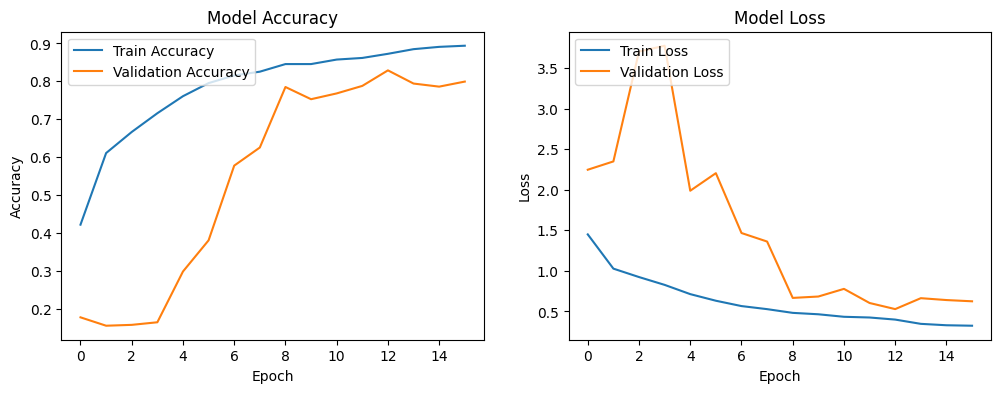

In [19]:
# Now plot the training and validation metrics
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(model.history['accuracy'], label='Train Accuracy')
plt.plot(model.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(model.history['loss'], label='Train Loss')
plt.plot(model.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.show()

In [20]:
loss,accuracy=KerasModel.evaluate(x_test,y_test)

94/94 ━━━━━━━━━━━━━━━━━━━━ 23s 151ms/step - accuracy: 0.7999 - loss: 0.5590


In [21]:
print(f'loss is {loss}')
print(f'accuracy is {accuracy}')

loss is 0.5784242153167725
accuracy is 0.8073333501815796


In [22]:
y_result = KerasModel.predict(x_pred)

y_result

229/229 ━━━━━━━━━━━━━━━━━━━━ 25s 104ms/step


array([[2.1323168e-01, 4.5914479e-05, 4.2344999e-04, 1.6512400e-05,
        1.4528993e-04, 7.8613710e-01],
       [1.1869728e-06, 5.9064313e-09, 5.3233609e-05, 2.8936207e-05,
        9.9991572e-01, 9.4576433e-07],
       [1.5907746e-13, 1.0000000e+00, 5.7554622e-10, 1.4163984e-16,
        8.3366200e-17, 2.7504450e-11],
       ...,
       [1.0070662e-02, 7.9855584e-03, 3.4380132e-01, 3.1746122e-01,
        3.0418020e-01, 1.6500983e-02],
       [1.7856467e-15, 1.0000000e+00, 5.0464299e-11, 2.4055990e-17,
        8.5895055e-19, 1.1836005e-13],
       [4.6224683e-05, 2.6927992e-06, 4.9876953e-03, 5.4304171e-03,
        9.8949826e-01, 3.4698001e-05]], dtype=float32)

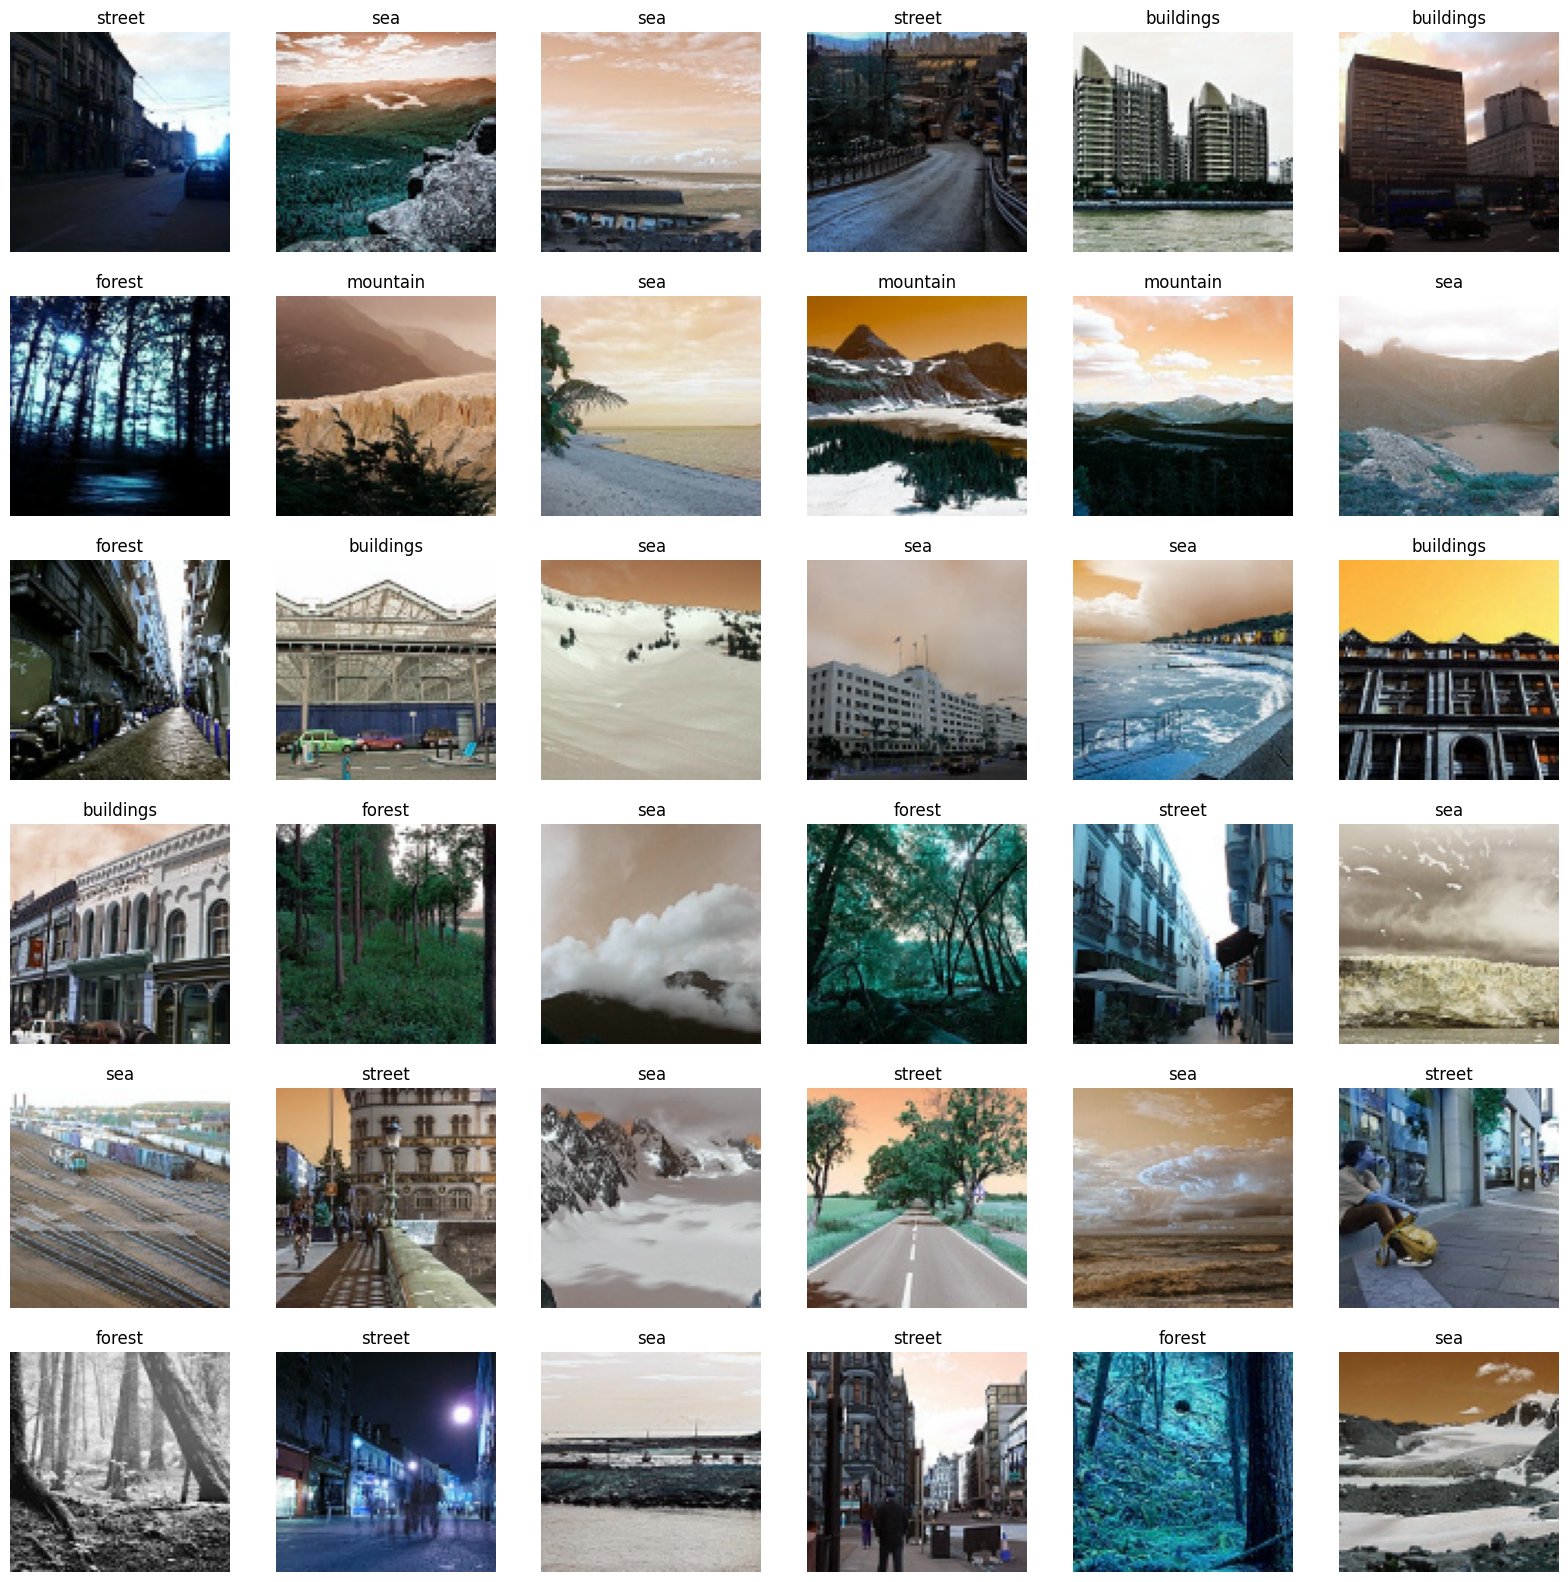

In [23]:
plt.figure(figsize=(20,20))
for n , i in enumerate(list(np.random.randint(0,len(x_pred),36))) :
    plt.subplot(6,6,n+1)
    plt.imshow(x_pred[i])
    plt.axis('off')
    plt.title(get_code(np.argmax(y_result[i])))

In [24]:
# from sklearn.metrics import classification_report

# # Print classification report
# print(classification_report(y_test, y_pred_classes, target_names=class_labels))


In [25]:
y_pred = KerasModel.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

labels = list(code.values())
target_names = list(code.keys())
report = classification_report(y_test, y_pred_classes, labels=labels, target_names=target_names)

print(report)

from sklearn.metrics import classification_report

report = classification_report(y_test, y_pred_classes, labels=labels, target_names=target_names)

print(report)

precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred_classes, labels=labels, average='weighted')

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1_score:.4f}')


94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 79ms/step
              precision    recall  f1-score   support

   buildings       0.87      0.81      0.84       437
      forest       0.88      0.99      0.93       474
     glacier       0.90      0.46      0.61       553
    mountain       0.75      0.80      0.78       525
         sea       0.67      0.95      0.79       510
      street       0.88      0.87      0.88       501

    accuracy                           0.81      3000
   macro avg       0.83      0.81      0.80      3000
weighted avg       0.82      0.81      0.80      3000

              precision    recall  f1-score   support

   buildings       0.87      0.81      0.84       437
      forest       0.88      0.99      0.93       474
     glacier       0.90      0.46      0.61       553
    mountain       0.75      0.80      0.78       525
         sea       0.67      0.95      0.79       510
      street       0.88      0.87      0.88       501

    accuracy                         

## In the code above, I have provided you with a written code, but it contains errors. Each of you must trace the errors and improve the accuracy for each model, recording the changes in the table below. Then, answer the following questions.

| Network          | Accuracy | Recall | Precision | F1-Score |
|------------------|----------|--------|-----------|----------|
| Your CNN model   |   0.81   |0.8073  |  0.8249   |  0.7980  |
| VGG16            |   0.85   | 0.8487 |  0.8554   |  0.8467  |
| VGG19            |  0.67    | 0.6743 |  0.7393   |  0.6370  |
| Inception_V3     | 0.87     | 0.8693 |0.8719     | 0.8692   |
| RasNet152V2      |0.59      | 0.5937 | 0.6612    | 0.5707   |


models are saved in this link:
https://drive.google.com/drive/folders/1MBBe5P_spSX1CMMKjtXZsW4eaa0qP1pL




# Experimental Results